In [212]:

# code here
import sys
import cv2
from datetime import datetime
import matplotlib.pyplot as plt

sys.path.insert(0, '../Modules/')

from Modules import Commons
from Modules import Kernels

In [30]:
import importlib

importlib.reload(Commons)  # Reload the module
importlib.reload(Kernels)  # Reload the module

<module 'Modules.Kernels' from '/Users/gabrielsantos/PycharmProjects/pythonProject/pgc111-labs-2023/Modules/Kernels.py'>

In [34]:
from Modules.Commons import *
from Modules.Kernels import *


In [219]:
#Defining the ImageProcessor Class
class ImageProcessor:
    def __init__(self, img):
        self.img = img
        self.height = img.shape[0]
        self.width = img.shape[1]
        self.label = 1
        self.label_matrix = np.zeros((self.height, self.width), dtype=np.uint16)
        self.components = []

    def binarize(self, threshold):
        self.img[self.img > threshold] = 255
        self.img[self.img <= threshold] = 0
        plt.title('Binarized')
        plt.imshow(self.img, cmap='gray_r', vmin=0, vmax=255)

    def print_image(self):
        plt.imshow(self.img)
        plt.show()

    def print_label_matrix(self):
        plt.imshow(self.label_matrix, cmap="gray")
        plt.show()

    def _debug_image(self):
        print(self.img.shape)
        values, counts = np.unique(self.img, return_counts=True)
        print("Image has {} different values: ".format(len(values)) + ", ".join(str(v) for v in values))
        print("Counts: " + ", ".join(str(c) for c in counts))
        print(self.img)

    def _debug_components(self):
        print("There are {} components! ".format(len(self.components)))
        #for i in range(len(self.components)):
        #    print("Component {}: ".format(i) + ", ".join(str(c) for c in self.components[i]))

    def _reset(self):
        self.label = 1
        self.label_matrix = np.zeros((self.height, self.width), dtype=np.uint16)
        self.components = []

    def _add_equivalence(self, label1, label2):
        eq_found = False
        comp = [label1, label2]
        for i in range(len(self.components)):
            if (label1 in self.components[i]) or (label2 in self.components[i]):
                eq_found = True
                self.components[i].extend(item for item in comp if item not in self.components[i])
                comp.clear()
                comp = self.components[i]

        if not eq_found:
            self.components.append([label1, label2])

    def _get_transitive_closure(self):
        return {item: min(sublist) for sublist in self.components if sublist for item in sublist}

    def _connect_n(self, n=4):
        self._reset()
        for i in range(self.height):
            for j in range(self.width):
                if self.img[i][j] == 255:
                    self._connect_pixel(i, j, n)

    def _connect_pixel(self, i, j, n):
        neighbors = [(i - 1, j), (i, j - 1)]

        if n == 8:
            neighbors.extend([(i - 1, j - 1), (i - 1, j + 1)])

        for ni, nj in neighbors:
            if self._is_valid_neighbor(ni, nj) and self.label_matrix[ni][nj] != 0:
                if self.label_matrix[i][j] == 0:
                    self.label_matrix[i][j] = self.label_matrix[ni][nj]
                elif self.label_matrix[i][j] != self.label_matrix[ni][nj]:
                    self._add_equivalence(self.label_matrix[ni][nj], self.label_matrix[i][j])

        if self.label_matrix[i][j] == 0:
            self.label_matrix[i][j] = self._get_new_label()
            self._add_equivalence(self.label_matrix[i][j], self.label_matrix[i][j])

    def _get_new_label(self):
        label = self.label
        self.label += 1
        return label

    def _is_valid_neighbor(self, i, j):
        return 0 <= i < self.height and 0 <= j < self.width

    def _solve_equivalence(self):
        self.components = [sublist for sublist in self.components if sublist]
        self._debug_components()
        dict_components = self._get_transitive_closure()
        for i in range(self.height):
            for j in range(self.width):
                if self.label_matrix[i][j] in dict_components:
                    self.label_matrix[i][j] = dict_components[self.label_matrix[i][j]]

    def get_components(self, neighborhood=4):
        self._connect_n(neighborhood)
        self._solve_equivalence()

    def export_to_file(self, filename):
        with open(filename, 'w') as file:
            for row in self.label_matrix:
                file.write(' '.join(map(str, row)) + '\n')


1)	A partir da imagem original obtenha as outras imagens conforme descrição

Desejamos separar linhas de círculos. Uma operação de abertura com um elemento estruturante na forma de círculo (definir o raio) faz essa tarefa.


In [108]:
# Test Logical Thresholding 
X = np.array([[255, 255, 0], 
              [0, 255, 0], 
              [0, 255, 0]])

print(X.astype(bool))

[[ True  True False]
 [False  True False]
 [False  True False]]


In [19]:
# @Test Matrices logical And 
# 3x3 matrices A and B 
A = np.array([[1, 1, 0], 
              [0, 1, 0], 
              [0, 1, 0]])
B = np.array([[1, 0, 0], 
              [1, 1, 0], 
              [1, 1, 1]])

# Compute the intersection by performing an element-wise AND operation
# intersection = np.sum(np.logical_and(A, B))
print(A[0:2, 0:2])
intersection = np.sum(np.logical_and(A[0:2, 0:2], B[0:2, 0:2]))

print(intersection)

[[1 1]
 [0 1]]
2


In [38]:
# @Test Padding 
print(padding(A, 0, 2, 0, 2))

[[1 1 0 0 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [112]:
# Creating function for dilation
def dilation(img, se, origin):
    # Creating a matrix with the same shape of the image
    dilated_img = np.zeros(img.shape, dtype=np.uint8)
    # get img shape
    x1, x2 = img.shape
    # get offsets 
    l, r, t, b = get_offsets(se, origin)
    # get padded image
    padded_img = padding(img, l, r, t, b)
    # get se shape 
    k1, k2 = se.shape
    # displacement of the origin
    for i in range(x1):
        for j in range(x2):
            sum_intersection = np.sum(np.logical_and(padded_img[i:i + k1, j:j + k2], se))
            dilated_img[i, j] = int(min(1, sum_intersection))

    return dilated_img


def erosion(img, se, origin):
    # Creating a matrix with the same shape of the image
    eroded_img = np.zeros(img.shape, dtype=np.uint8)
    # get img shape
    x1, x2 = img.shape
    # get offsets 
    l, r, t, b = get_offsets(se, origin)
    # get padded image
    padded_img = padding(img, l, r, t, b)
    # get se shape 
    k1, k2 = se.shape
    # displacement of the origin
    for i in range(x1):
        for j in range(x2):
            mask = np.logical_and(padded_img[i:i + k1, j:j + k2], se)
            r_intersection = np.logical_not(np.logical_xor(mask, se))
            eroded_img[i, j] = np.min(r_intersection)

    return eroded_img

In [113]:
# @Test Dilation
C = np.array([[1, 1, 1], 
              [1, 1, 1], 
              [1, 1, 1]])

# @Notes: The origin plays a huge role in the morphological operations
print(dilation(A, C, (0, 2)))

[[1 1 1]
 [0 1 1]
 [0 1 1]]


In [115]:
# @Test Erosion
D = np.array([[1, 1, 0], 
              [0, 1, 0], 
              [0, 1, 0]])

E = np.array([[0, 1, 0], 
              [0, 1, 0], 
              [0, 0, 0]])

# @Notes: The origin plays a huge role in the morphological operations
print(erosion(A, E, (1, 1)))

[[0 0 0]
 [0 1 0]
 [0 1 0]]


In [93]:
def get_circle_image(radius):
    # Creating a matrix with the same shape of the image
    img = np.zeros((radius * 2 + 1, radius * 2 + 1), dtype=np.uint8)
    # get img shape
    x1, x2 = img.shape

    for i in range(x1):
        for j in range(x2):
            if (i - radius) ** 2 + (j - radius) ** 2 <= radius ** 2 + 1:
                img[i, j] = 1

    return img

[[0 0 0 0 0 1 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]]


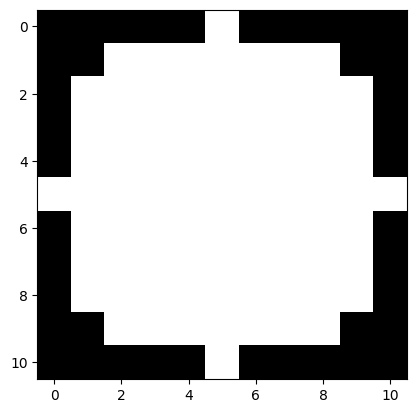

In [103]:
# @Test Circle Image
circle = get_circle_image(5)
print(circle)
plt.imshow(circle * 255, cmap='gray', vmin=0, vmax=255);

In [95]:
# Opening 
def opening(img, se, origin):
    return dilation(erosion(img, se, origin), se, origin)

# Closing
def closing(img, se, origin):
    return erosion(dilation(img, se, origin), se, origin)

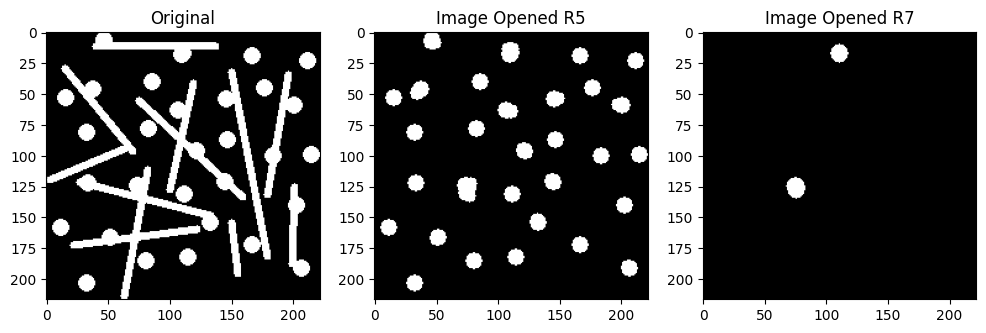

In [128]:
# Exercício #1 
img1 = cv2.imread("art3.png", cv2.IMREAD_GRAYSCALE)
# get circle image with radius x
se_circle = get_circle_image(5)
# get circle center
circle_center = (se_circle.shape[0] // 2, se_circle.shape[1] // 2)
img_result_v1 = opening(img1, se_circle, circle_center) * 255

se_circle = get_circle_image(7)
# get circle center
circle_center = (se_circle.shape[0] // 2, se_circle.shape[1] // 2)
img_result_v2 = opening(img1, se_circle, circle_center) * 255

# Printing
images = np.array([[img1, img_result_v1, img_result_v2]])
labels = np.array([['Original', 'Image Opened R5', 'Image Opened R7']])
print_images(labels, images, _figsize=(12, 12))


2)

a) Obter linhas verticais. Abertura com elemento estruturante vertical 3x9
b) Obter linhas horizontais. Abertura com elemento estruturante horizontal 9x3. Tente eliminar as linhas erradas usando uma máscara maior


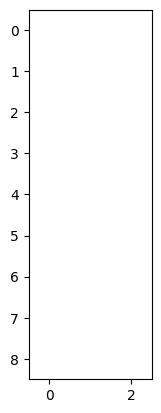

In [130]:
# get vertical line
se = np.ones((9, 3), dtype=np.uint8)
plt.imshow(se * 255, cmap='gray', vmin=0, vmax=255);

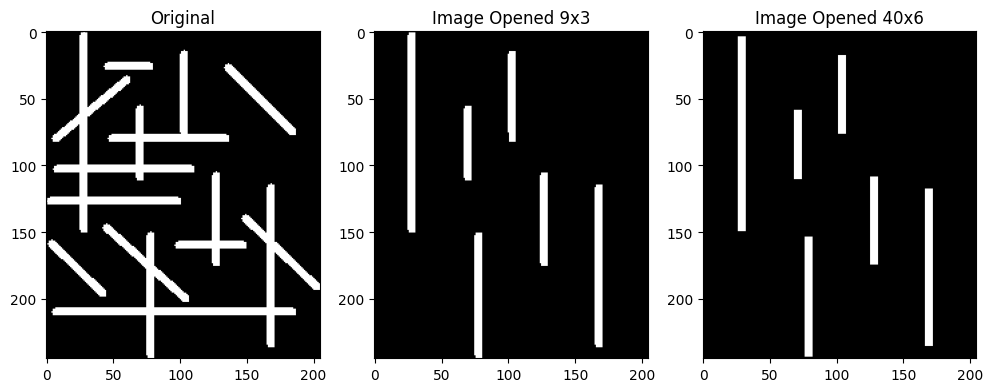

In [146]:
# Exercicio #2a Pegando linhas verticais 
img2 = cv2.imread("art2.png", cv2.IMREAD_GRAYSCALE)

# get vertical line
se = np.ones((9, 3), dtype=np.uint8)
# get circle center
origin = (se.shape[0] // 2, se.shape[1] // 2)
img_result_v1 = opening(img2, se, origin) * 255

# get vertical line
se = np.ones((40, 6), dtype=np.uint8)
# get circle center
origin = (se.shape[0] // 2, se.shape[1] // 2)
img_result_v2 = opening(img2, se, origin) * 255

# Printing
images = np.array([[img2, img_result_v1, img_result_v2]])
labels = np.array([['Original', 'Image Opened 9x3', 'Image Opened 40x6']])
print_images(labels, images, _figsize=(12, 12))

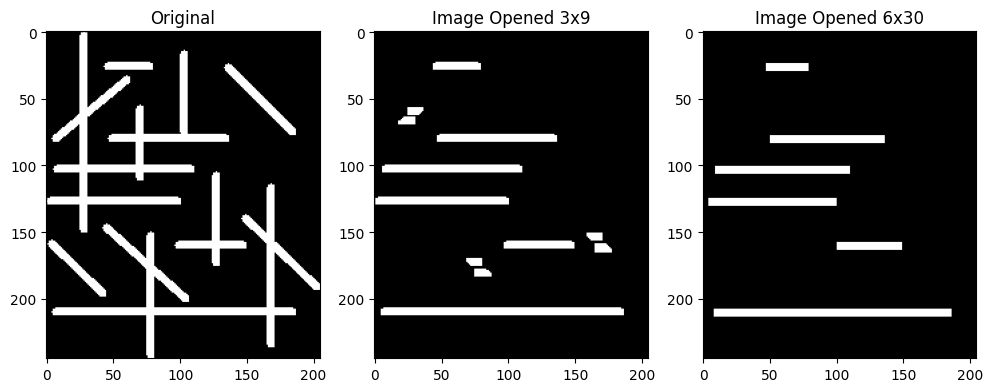

In [206]:
# Exercicio #2b Pegando linhas Horizontais 
img2 = cv2.imread("art2.png", cv2.IMREAD_GRAYSCALE)

# get vertical line
se = np.ones((3, 9), dtype=np.uint8)
# get circle center
origin = (se.shape[0] // 2, se.shape[1] // 2)
img_result_v1 = opening(img2, se, origin) * 255

# get vertical line
se = np.ones((6, 30), dtype=np.uint8)
# get circle center
origin = (se.shape[0] // 2, se.shape[1] // 2)
img_result_v2 = opening(img2, se, origin) * 255

# Printing
images = np.array([[img2, img_result_v1, img_result_v2]])
labels = np.array([['Original', 'Image Opened 3x9', 'Image Opened 6x30']])
print_images(labels, images, _figsize=(12, 12))

3)

a) Theshold (t=210)

b) Utilizando abertura com elemento circular de 11 pixels para reter as células grandes

c) É possível reter somente os objetos pequenos utilizando a operação abertura?

c) Creio que não pois a abertura é uma operação que remove ruídos, logo, se o objeto for pequeno (menor que o elemento estruturante), ele será removido

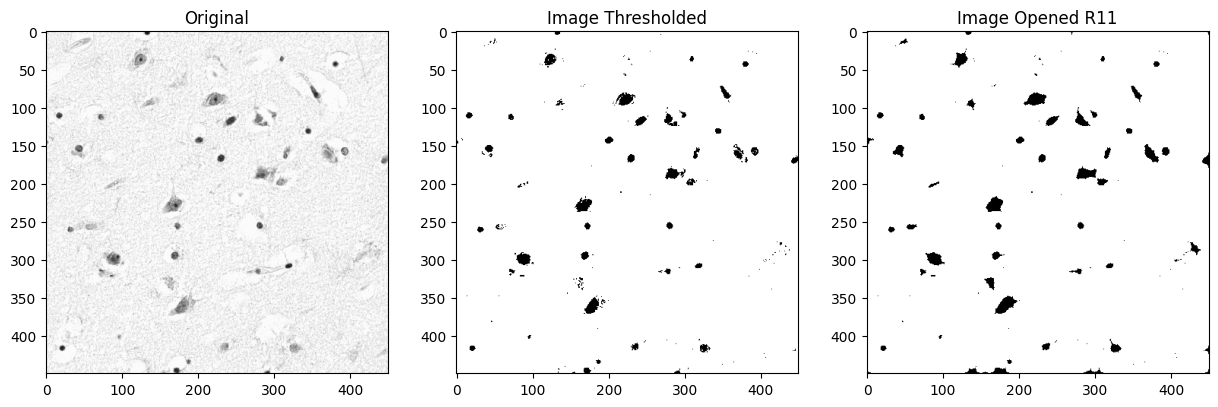

In [190]:
img3 = cv2.imread("cel4.png", cv2.IMREAD_GRAYSCALE)
# Com o threshold de 210 fica com muito ruído, logo, o threshold aplicado para melhor desempenho foi o de 180 
img3_thresholded = threshold_image(img3.copy(), 180)

# get circle image with radius 11 x 11: Aqui considerei a imagem toda com 11 pixels w e 11 pixels h, logo, o raio é 5
se_circle = get_circle_image(5)
# get circle center
circle_center = (se_circle.shape[0] // 2, se_circle.shape[1] // 2)
img_result_v1 = opening(img3_thresholded, se_circle, circle_center) * 255

# Printing
images = np.array([[img3, img3_thresholded, img_result_v1]])
labels = np.array([['Original', 'Image Thresholded', 'Image Opened R11']])
print_images(labels, images, _figsize=(15, 15))


4)
Utilizando os conceitos já aprendidos na disciplina, faça um código que calcula a quantidade de objetos da imagem abaixo. Pode-se utilizar funções prontas do opencv (não para realizar a contagem em si, mas para realizar os passos necessários)

Image Shape: (3456, 4608)
Start:  10:46:19.524599
Number of beans: 117
1 18063
2 11786
3 39794
4 21921
5 30417
6 42316
7 27821
8 36653
9 21808
10 28073
11 29749
12 971
13 31342
14 30716
15 12579
16 5427
17 4982
18 58544
19 23575
20 32838
21 27519
22 30114
23 15316
24 901
25 25866
26 32050
27 37740
28 2281
29 29952
30 18516
31 27700
32 40222
33 31947
34 5171
35 971
36 31223
37 36651
38 15080
39 32988
40 34236
41 24284
42 29165
43 37281
44 39039
45 30764
46 32264
47 26054
48 3707
49 4688
50 38085
51 24881
52 32432
53 1542
54 22484
55 20671
56 16989
57 28163
58 25189
59 26350
60 10242
61 25729
62 1844
63 29967
64 3896
65 21347
66 26483
67 24389
68 2107
69 30957
70 30395
71 30988
72 1229
73 936
74 38146
75 23996
76 3168
77 34936
78 31669
79 35288
80 35983
81 13355
82 36276
83 31290
84 13037
85 9852
86 34459
87 45272
88 4979
89 1652
90 1625
91 31031
92 1242
93 39504
94 32847
95 33077
96 39998
97 25432
98 33978
99 20778
100 950
101 36321
102 31305
103 40488
104 35724
105 971
106 950
107 3216

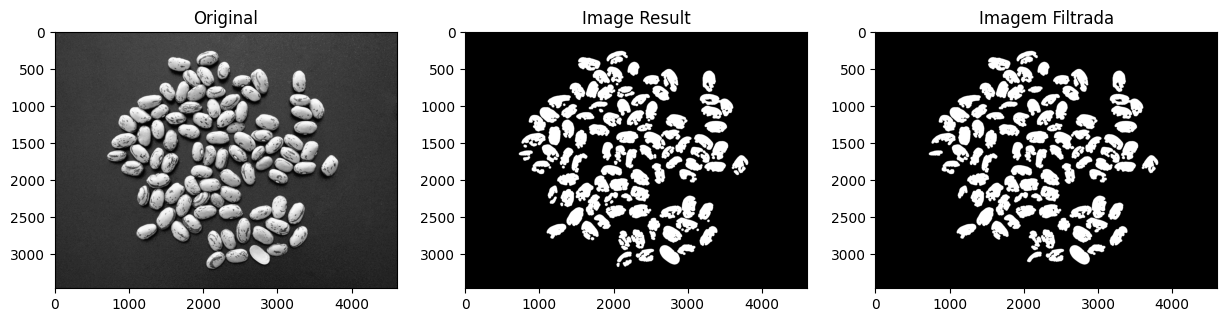

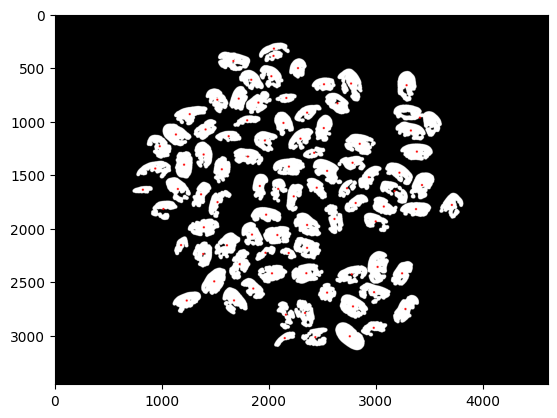

In [239]:
img4 = cv2.imread("feijao.jpg", cv2.IMREAD_GRAYSCALE)
print("Image Shape: " + str(img4.shape))
# apply threshold
img4_thresholded = threshold_image(img4.copy(), 115)
# closing with small object
se_circle = get_circle_image(17)
# get circle center
circle_center = (se_circle.shape[0] // 2, se_circle.shape[1] // 2)
print("Start: ", datetime.now().time())
img_result_v1 = opening(img4_thresholded, se_circle, circle_center) * 255
#img_result_v1 = erosion(img4_thresholded, se_circle, circle_center) * 255

# n_objects, labels = cv2.connectedComponents(img_result_v1)
n_objects, labels, stats, centroids = cv2.connectedComponentsWithStats(img_result_v1, connectivity=8)
print("Number of beans: " + str(n_objects - 1))

# Define a minimum component size threshold
min_component_size = 9000  # Adjust this value based on your image

# Initialize a mask for large components
large_components_mask = np.zeros_like(img_result_v1)
filtered_image = np.zeros_like(img_result_v1)

# Iterate through the labeled components
for label in range(1, n_objects):  # Start from 1 to exclude background
    # Create a mask for the current label (transforming from boolean to uint8)
    component_mask = np.uint8(labels == label)

    # Calculate the size of the component (counting the pixels different from black)
    component_size = cv2.countNonZero(component_mask)
    print(label, component_size)
    # If the component size is above the threshold, add it to the large components mask
    if component_size >= min_component_size:
        large_components_mask += component_mask
        filtered_image[labels == label] = 255  # Keep the component
#    if stats[label, cv2.CC_STAT_AREA] >= min_component_size:
#        filtered_image[labels == label] = 255  # Keep the component

# Create a colored version of the labeled image for visualization
colored_image = cv2.cvtColor(filtered_image, cv2.COLOR_GRAY2BGR)
# Define colors for drawing points (you can customize these)
point_color = (255, 0, 0)  # Red in BGR color format
point_radius = 10  # Radius of the drawn point

# Re-label the large components
#num_large_components, labeled_large_components = cv2.connectedComponents(large_components_mask)
num_large_components, labeled_large_components, stats_lc, centroids_lc = cv2.connectedComponentsWithStats(large_components_mask, connectivity=8)
# Iterate through the labeled components
for label in range(1, num_large_components):  # Start from 1 to exclude background
    centroid_x, centroid_y = centroids_lc[label]  # Get centroid coordinates
    centroid_position = (int(centroid_x), int(centroid_y))
    # Draw a colored point at the centroid position
    cv2.circle(colored_image, centroid_position, point_radius, point_color, -1)  # -1 fills the circle  
    
# Subtract 1 from the total count to exclude the background label (0)
num_large_objects = num_large_components - 1

# Display the total number of large connected components (objects)
print("Total Number of Large Connected Components (Objects):", num_large_objects)

print("End: ", datetime.now().time())

# Printing
images = np.array([[img4, img_result_v1, filtered_image]])
labels = np.array([['Original', 'Image Result', 'Imagem Filtrada']])
print_images(labels, images, _figsize=(15, 15))
plt.imshow(colored_image);

5.  Utilize a transformada hit or miss para localizar o logotipo da UFU. Escolha um deles

Start:  00:20:13.963396


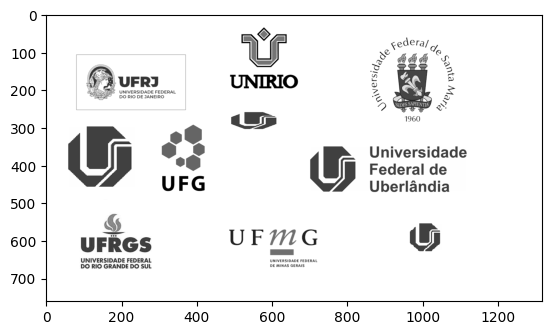

In [211]:
img5 = cv2.imread("logotipos.png", cv2.IMREAD_GRAYSCALE)
# print exact time
print("Start: ", datetime.now().time())

plt.imshow(img5, cmap='gray', vmin=0, vmax=255);

  6. Utilize operadores morfológicos para extração de fronteiras dos feijões. Mostre o resultado junto com a imagem original